In [1]:
from src.utils import *
from src.preprocess import clean_spacy_tokens
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
from functools import reduce

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pierr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
DOCS_PATH = 'data/en_core_web_lg.jsonl'
MONTHS = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [3]:
docs = read_jsonl(DOCS_PATH)

In [4]:
df = pd.DataFrame(docs, columns=['path', 'birthDate', 'birthPlace', 'deathDate'])
df.head()

,path,birthDate,birthPlace,deathDate
0,http://dbpedia.org/resource/Cab_Calloway,1907-12-25,"http://dbpedia.org/resource/Rochester,_New_York",1994-11-18
1,http://dbpedia.org/resource/Cabell_Breckinridge,1788-07-14,"http://dbpedia.org/resource/Albemarle_County,_...",1823-09-01
2,http://dbpedia.org/resource/Cabeção_(footballer),1930-08-23,http://dbpedia.org/resource/Brazil,2020-01-06
3,http://dbpedia.org/resource/Cabiria_Andreian_C...,1928-02-19,http://dbpedia.org/resource/Iași,2018-05-22
4,http://dbpedia.org/resource/Cabo_Almi,1962-12-17,http://dbpedia.org/resource/Jardim_Olinda,2021-05-24


In [5]:
df['tokens'] = [clean_spacy_tokens(doc['abstract']) for doc in docs]
df.head()

,path,birthDate,birthPlace,deathDate,tokens
0,http://dbpedia.org/resource/Cab_Calloway,1907-12-25,"http://dbpedia.org/resource/Rochester,_New_York",1994-11-18,"[Cabell, Calloway, III, December, November, am..."
1,http://dbpedia.org/resource/Cabell_Breckinridge,1788-07-14,"http://dbpedia.org/resource/Albemarle_County,_...",1823-09-01,"[Joseph, Cabell, Breckinridge, July, September..."
2,http://dbpedia.org/resource/Cabeção_(footballer),1930-08-23,http://dbpedia.org/resource/Brazil,2020-01-06,"[Luís, Morais, August, January, know, Cabeção,..."
3,http://dbpedia.org/resource/Cabiria_Andreian_C...,1928-02-19,http://dbpedia.org/resource/Iași,2018-05-22,"[Cabiria, Andreian, Cazacu, February, May, rom..."
4,http://dbpedia.org/resource/Cabo_Almi,1962-12-17,http://dbpedia.org/resource/Jardim_Olinda,2021-05-24,"[José, Almi, Pereira, Moura, full, name, Cabo,..."


In [6]:
df['astral_sign'] = df.birthDate.apply(date_to_astral)
df.head()

,path,birthDate,birthPlace,deathDate,tokens,astral_sign
0,http://dbpedia.org/resource/Cab_Calloway,1907-12-25,"http://dbpedia.org/resource/Rochester,_New_York",1994-11-18,"[Cabell, Calloway, III, December, November, am...",Capricorn
1,http://dbpedia.org/resource/Cabell_Breckinridge,1788-07-14,"http://dbpedia.org/resource/Albemarle_County,_...",1823-09-01,"[Joseph, Cabell, Breckinridge, July, September...",Cancer
2,http://dbpedia.org/resource/Cabeção_(footballer),1930-08-23,http://dbpedia.org/resource/Brazil,2020-01-06,"[Luís, Morais, August, January, know, Cabeção,...",Virgo
3,http://dbpedia.org/resource/Cabiria_Andreian_C...,1928-02-19,http://dbpedia.org/resource/Iași,2018-05-22,"[Cabiria, Andreian, Cazacu, February, May, rom...",Aquarius
4,http://dbpedia.org/resource/Cabo_Almi,1962-12-17,http://dbpedia.org/resource/Jardim_Olinda,2021-05-24,"[José, Almi, Pereira, Moura, full, name, Cabo,...",Sagittarius


words = reduce(lambda a, b: a | set([t.lower() for t in b]), df['tokens'], set())

print(len(vectorizer.vocabulary_), len(features), len(words))

def check(x):
    word = 'apple'
    for t in x:
        if t.lower() == word:
            print(t, x)
_ = df['tokens'].apply(check)

In [15]:
vectorizer = CountVectorizer(lowercase=False, token_pattern=r'([^\s]+)')
X = vectorizer.fit_transform(df['tokens'].apply(lambda x: ' '.join(x)))
features = vectorizer.get_feature_names_out()
freqs = pd.DataFrame(zip(features, np.asarray((X != 0).astype(int).mean(axis=0)).flatten()), columns=['word', 'freq'])
freqs.sort_values('freq', ascending=False)

,word,freq
106463,bear,0.332554
105091,american,0.219793
122394,play,0.191968
125842,serve,0.181670
117368,know,0.173582
...,...,...
56059,Maddo,0.000021
56058,Maddly,0.000021
56056,Maddin,0.000021
56051,Maddala,0.000021


In [29]:
def terms_to_docs(x):
    return np.asarray((x != 0).astype(int).mean(axis=0)).flatten()

vectorizer = CountVectorizer(lowercase=False, token_pattern=r'([^\s]+)')
vectorizer = vectorizer.fit(df['tokens'].apply(lambda x: ' '.join(x)))
features = vectorizer.get_feature_names_out()

X = vectorizer.transform(df['tokens'].apply(lambda x: ' '.join(x)))
X = terms_to_docs(X)
freqs = pd.DataFrame(
    zip(features, X), 
    columns=['word', 'all_freq']    
)

for asign in df['astral_sign'].unique():
    X = vectorizer.transform(df[df['astral_sign'] == asign]['tokens'].apply(lambda x: ' '.join(x)))
    X = terms_to_docs(X)
    freqs[f'{asign}_freq'] = X

freqs.describe()

,all_freq,Capricorn_freq,Cancer_freq,Virgo_freq,Aquarius_freq,Sagittarius_freq,Gemini_freq,Taurus_freq,Aries_freq,Pisces_freq,Libra_freq,Scorpio_freq,Leo_freq
count,139553.000000,139553.000000,139553.000000,139553.000000,139553.000000,139553.000000,139553.000000,139553.000000,139553.000000,139553.000000,139553.000000,139553.000000,139553.000000
mean,0.000241,0.000243,0.000240,0.000249,0.000240,0.000243,0.000244,0.000238,0.000232,0.000241,0.000244,0.000238,0.000243
std,0.002762,0.003187,0.003204,0.003276,0.003170,0.003254,0.003211,0.003179,0.003117,0.003228,0.003263,0.003210,0.003267
min,0.000021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.332554,0.672962,0.686441,0.701843,0.641824,0.708262,0.653286,0.675676,0.635885,0.686141,0.713482,0.697860,0.717324


In [39]:
freqs[~freqs['word'].isin(MONTHS)].describe()

,all_freq,Capricorn_freq,Cancer_freq,Virgo_freq,Aquarius_freq,Sagittarius_freq,Gemini_freq,Taurus_freq,Aries_freq,Pisces_freq,Libra_freq,Scorpio_freq,Leo_freq
count,139541.000000,139541.000000,139541.000000,139541.000000,139541.000000,139541.000000,139541.000000,139541.000000,139541.000000,139541.000000,139541.000000,139541.000000,139541.000000
mean,0.000228,0.000230,0.000227,0.000236,0.000227,0.000230,0.000231,0.000225,0.000219,0.000228,0.000231,0.000225,0.000230
std,0.002370,0.002357,0.002375,0.002452,0.002353,0.002411,0.002413,0.002349,0.002299,0.002390,0.002403,0.002360,0.002412
min,0.000021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.332554,0.321301,0.334746,0.341075,0.334641,0.330465,0.339555,0.340596,0.327478,0.322458,0.327258,0.336237,0.335725


In [38]:
for col in freqs.columns:
    print(col, freqs[~freqs['word'].isin(MONTHS)].sort_values(col, ascending=False)['word'][:5].values)

word ['𑢺𑣁𑣌𑣉' '𑢷𑣉𑣔𑣜𑣁' '𑢬𑣉𑣚' '𑢫𑣃𑣜𑣃' 'ﻧﻭﺍﺏ']
all_freq ['bear' 'american' 'play' 'serve' 'know']
Capricorn_freq ['bear' 'american' 'play' 'know' 'serve']
Cancer_freq ['bear' 'american' 'play' 'serve' 'know']
Virgo_freq ['bear' 'american' 'play' 'serve' 'know']
Aquarius_freq ['bear' 'american' 'play' 'know' 'serve']
Sagittarius_freq ['bear' 'american' 'play' 'serve' 'know']
Gemini_freq ['bear' 'american' 'play' 'serve' 'know']
Taurus_freq ['bear' 'american' 'play' 'serve' 'know']
Aries_freq ['bear' 'american' 'play' 'serve' 'know']
Pisces_freq ['bear' 'american' 'play' 'serve' 'know']
Libra_freq ['bear' 'american' 'serve' 'know' 'play']
Scorpio_freq ['bear' 'american' 'play' 'serve' 'know']
Leo_freq ['bear' 'american' 'play' 'serve' 'know']


<AxesSubplot: >

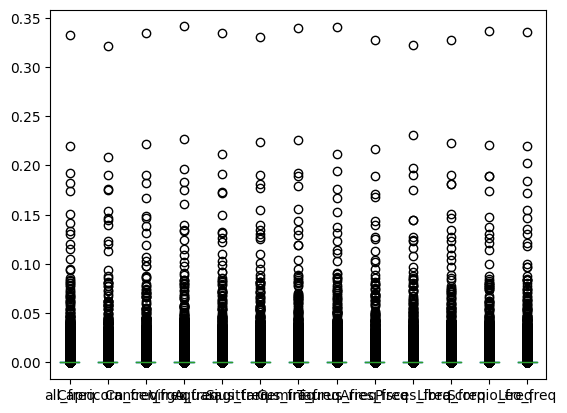

In [69]:
freqs[~freqs['word'].isin(MONTHS)].plot.box()

In [66]:
TARGET = 'bear'
vectorizer = CountVectorizer(lowercase=False, token_pattern=r'([^\s]+)')
X = vectorizer.fit_transform(df['tokens'].apply(lambda x: ' '.join(x)))
features = vectorizer.get_feature_names_out()
tindex = list(features).index(TARGET)
df[(X[:, tindex] == 0).toarray().flatten()]

# freqs = pd.DataFrame(zip(features, np.asarray((X != 0).astype(int).mean(axis=0)).flatten()), columns=['word', 'freq'])
# freqs.sort_values('freq', ascending=False)

c:\Users\pierr\.conda\envs\data-td\lib\site-packages\IPython\core\interactiveshell.py:3442: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


,path,birthDate,birthPlace,deathDate,tokens,astral_sign
0,http://dbpedia.org/resource/Cab_Calloway,1907-12-25,"http://dbpedia.org/resource/Rochester,_New_York",1994-11-18,"[Cabell, Calloway, III, December, November, am...",Capricorn
1,http://dbpedia.org/resource/Cabell_Breckinridge,1788-07-14,"http://dbpedia.org/resource/Albemarle_County,_...",1823-09-01,"[Joseph, Cabell, Breckinridge, July, September...",Cancer
2,http://dbpedia.org/resource/Cabeção_(footballer),1930-08-23,http://dbpedia.org/resource/Brazil,2020-01-06,"[Luís, Morais, August, January, know, Cabeção,...",Virgo
3,http://dbpedia.org/resource/Cabiria_Andreian_C...,1928-02-19,http://dbpedia.org/resource/Iași,2018-05-22,"[Cabiria, Andreian, Cazacu, February, May, rom...",Aquarius
5,http://dbpedia.org/resource/Cabo_Anselmo,1942-02-13,http://dbpedia.org/resource/Itaporanga_d'Ajuda,2022-03-15,"[José, Anselmo, do, Santos, February, March, k...",Aquarius
...,...,...,...,...,...,...
46599,http://dbpedia.org/resource/Miriam_Morandy,1961-10-27,http://dbpedia.org/resource/Maturín,None,"[Miriam, del, Valle, Morandy, Mijares, venezue...",Scorpio
46603,http://dbpedia.org/resource/Thomas_Charles_Munger,1861-07-07,http://dbpedia.org/resource/Ohio,1941-11-29,"[Thomas, Charles, Munger, July, November, Unit...",Cancer
46605,http://dbpedia.org/resource/Ben_Barres,1954-09-13,"http://dbpedia.org/resource/West_Orange,_New_J...",2017-12-27,"[Ben, Barres, September, December, american, n...",Virgo
46609,http://dbpedia.org/resource/Joe_Klugmann,1895-03-26,"http://dbpedia.org/resource/St._Louis,_Missouri",1951-07-18,"[Josie, Joe, Klugmann, March, July, former, pr...",Aries
